In [1]:
"""
Используется активное иттербиевое волокно со следующими параметрами: волокно двойка,
диаметр жилы волокна 10 мкм, диаметр оболочки каждого из соприкасающихся световодов 125
мкм, концентрация ионов иттербия 4000 ppm, матрица фосфатная сечения взаимодействия
приведены в файле “Yb_cross_sections.xls”, время жизни в возбуждённом состоянии 1.54 мс.
Промоделировать работу следующего непрерывного иттербиевого волоконного усилителя:
a.
Входной сигнал 10 мВт
b.
Накачка с двух сторон по 2 Вт с каждой стороны.
c.
Длина волны сигнала 1030 нм, накачки 962 нм
d.
Длина волокна 20 м
Найти распределение мощностей сигнала, накачки и распределение инверсии.
Если вы решаете задачу одной из разновидностей метода коллокаций, то в
качестве начального приближения удобно взять условие экспоненциального
затухания накачки.
"""

'\nИспользуется активное иттербиевое волокно со следующими параметрами: волокно двойка,\nдиаметр жилы волокна 10 мкм, диаметр оболочки каждого из соприкасающихся световодов 125\nмкм, концентрация ионов иттербия 4000 ppm, матрица фосфатная сечения взаимодействия\nприведены в файле “Yb_cross_sections.xls”, время жизни в возбуждённом состоянии 1.54 мс.\nПромоделировать работу следующего непрерывного иттербиевого волоконного усилителя:\na.\nВходной сигнал 10 мВт\nb.\nНакачка с двух сторон по 2 Вт с каждой стороны.\nc.\nДлина волны сигнала 1030 нм, накачки 962 нм\nd.\nДлина волокна 20 м\nНайти распределение мощностей сигнала, накачки и распределение инверсии.\nЕсли вы решаете задачу одной из разновидностей метода коллокаций, то в\nкачестве начального приближения удобно взять условие экспоненциального\nзатухания накачки.\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
from numpy import pi
from scipy.integrate import solve_ivp
from scipy.integrate import solve_bvp

import scipy.integrate as integrate
from scipy.integrate import quad
from scipy.integrate import simpson

In [46]:
Pp0 = 2 #Wt с каждой стороны
PpL = 2
Ps = 10e-3 #Wt

L = 4 #m
d = 10e-6
D = 125e-6
Aeffs = pi * d**2 / 4
Aeffp = pi * D**2 / 4 * 2

N = 4000 * 6.62e22
tau = 1.54e-3
h = 6.63e-34
n = 1.44
c = 3e8 / 1.44

lmbda_p = 975 # in nm
lmbda_s = 1030 # in nm


In [5]:

def Yb_amplifier(s_12_p, s_21_p, s_12_s, s_21_s, 
                  tau, c, h,  N, L, Aeffs, Aeffp, P_init):
    
    def fun(z, P): #right hand statement of a system
        # print('z shape ' , z.shape, 'P shape', P.shape)
        # P = Pp0, PpL, Ps)
        dP = np.zeros((3, len(z)))
        Ip0 = P[0] / (( Aeffp * h * c**2 )/lmbda_p)
        IpL = P[1] / (( Aeffp * h * c**2 )/lmbda_p)
        Is0 = P[2] / (( Aeffs * h * c**2 )/lmbda_s)
        
        NN = np.ones(len(z)) * N
        N2 = (NN * (s_12_p * (Ip0 + IpL) + s_12_s * Is0) / 
              ((Ip0 + IpL)* (s_12_p + s_21_p) +  Is0 * (s_12_s + s_21_s) + 1 / (tau * c)))
        
        N1 = NN - N2
    
        dP[0] = P[0] * (s_21_p * N2 - s_12_p * N1) * Aeffs / Aeffp
        dP[1] = P[1] * (s_21_p * N2 - s_12_p * N1) * Aeffs / Aeffp * (-1)
        dP[2] = P[2] * (s_21_s * N2 - s_12_s * N1)
        # print('dP shape', dP.shape)
        return (dP)
    
    def bc(ya, yb):
        # print(ya, yb)
        return np.array([ya[0] - P_init[0], yb[1] - P_init[1], ya[2] - P_init[2]])

    za = np.linspace(0, L/20, 5)
    zb = np.linspace(L* (1 - 1/20), L, 5)

    alpha_p = Aeffs/Aeffp * N * s_12_p

    def Pa(z, P_init): #approximation on left boundry
        PP = np.zeros(3)
        PP = [P_init[0]  * np.exp(- alpha_p * z), 
            np.ones(len(z)) * 0, 
            np.ones(len(z)) * P_init[2]] 
        return PP

    def Pb(z, P_init): #approximation on right boundary
        PP = np.zeros(3)
        PP = [np.ones(len(z)) * 0,
            P_init[1] * np.exp(alpha_p * (z - z[-1])), 
            np.ones(len(z)) * P_init[2]]
    
        return PP

    # P_init = (Pp0, PpL, Ps)
    Z_guess = np.concatenate((za, zb))
    P_guess = np.concatenate((Pa(za, P_init), Pb(zb, P_init)), axis = 1)

    # print(fun(Z_guess, P_guess))
    answer = solve_bvp(fun, bc, Z_guess, P_guess)
    return answer
    # return 0




In [30]:

sigma = pandas.read_csv('Yb_cross_sections.csv', sep=';').to_numpy()
s_12_p = np.interp(lmbda_p, sigma[:, 0], sigma[:, 2])
s_21_p = np.interp(lmbda_p, sigma[:, 0], sigma[:, 1])
s_12_s = np.interp(lmbda_s, sigma[:, 0], sigma[:, 2])
s_21_s = np.interp(lmbda_s, sigma[:, 0], sigma[:, 1])

In [47]:
def Inversion(s_12_p, s_21_p, s_12_s, s_21_s, 
                  tau, c, h,  N, L, Aeffs, Aeffp, P):
        Ip0 = P[0] / (( Aeffp * h * c**2 )/lmbda_p)
        IpL = P[1] / (( Aeffp * h * c**2 )/lmbda_p)
        Is0 = P[2] / (( Aeffs * h * c**2 )/lmbda_s)
        
        N2 = (N * (s_12_p * (Ip0 + IpL) + s_12_s * Is0) / 
              ((Ip0 + IpL)* (s_12_p + s_21_p) +  Is0 * (s_12_s + s_21_s) + 1 / (tau * c)))
        return N2/N * 100
    
    

In [38]:
#число фотонов, интеграл ч
answer = Yb_amplifier(s_12_p, s_21_p, s_12_s, s_21_s, 
                  tau, c, h,  N, L, Aeffs, Aeffp, (Pp0, PpL, Ps))

model eff:  0.9240813751888279
theor eff:  0.9466019417475728


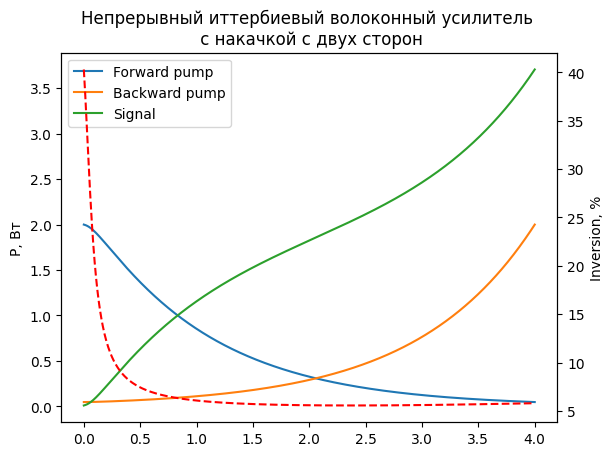

In [39]:
%matplotlib inline
fig, ax1 = plt.subplots()
z = np.linspace(0, L, 1000)
ax1.plot(z, answer.sol(z)[0], label = 'Forward pump')
ax1.plot(z, answer.sol(z)[1], label = 'Backward pump')
ax1.plot(z, answer.sol(z)[2], label = 'Signal')

ax2 = ax1.twinx()
Inv = Inversion(s_12_p, s_21_p, s_12_s, s_21_s, 
                  tau, c, h,  N, L, Aeffs, Aeffp, answer.sol(z))
ax2.plot(z, Inv, 'r--')
# plt.grid()
ax1.legend()
plt.title('Непрерывный иттербиевый волоконный усилитель \n с накачкой с двух сторон')
plt.xlabel('L, м')
ax1.set_ylabel('P, Вт')
ax2.set_ylabel('Inversion, %')

Eff = (answer.sol(z)[2][-1] - answer.sol(z)[2][0])/(Pp0 + PpL)

print('model eff: ', Eff)
print('theor eff: ', lmbda_p/lmbda_s)

In [9]:
# 1 wt both sides: 0.8116958700557094
# 2 wt forward:    0.811955627277739
# 2 wt backward:   0.8118647022219317

Посчитаем спектральную зависимость усиления в стационарном случае:

7.283010970240608e+25


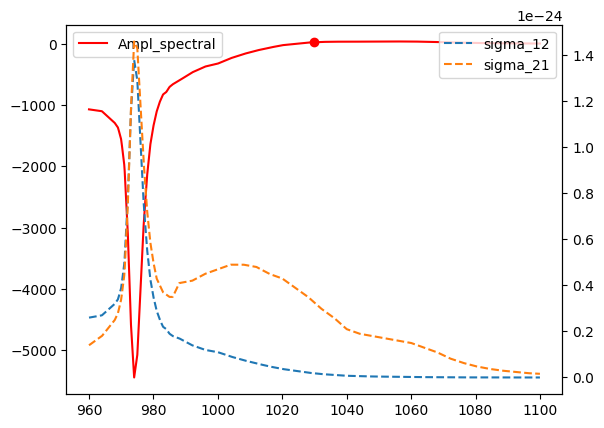

In [40]:
# sigma = pandas.read_csv('Yb_cross_sections.csv', sep=';').to_numpy()

def s_12(lmbda, sigma):
    return np.interp(lmbda, sigma[:, 0], sigma[:, 2])

def s_21(lmbda, sigma):
    return np.interp(lmbda, sigma[:, 0], sigma[:, 1])

def Ampl(lmbda_, sigma_, N2_int_, N_, L_):
    S_21 = s_21(lmbda_, sigma_)
    S_12 = s_12(lmbda_, sigma_)
    return (S_21 + S_12) * N2_int_ - S_12 * N_ * L_


# Инверсия посчитана по честному ранее
N2 = N * Inv /100 #Inv = N2 / N
# Интегральная инверсия населенностей [м]
N2_int = simpson(N2, z)
print(N2_int)

lmbda_1 = 960
lmbda_2 = 1100
Lmbdas_s = np.linspace(lmbda_1, lmbda_2, 1000)

params_Ampl = [sigma, N2_int, N, L]
Ampl_spectral = Ampl(Lmbdas_s, *params_Ampl)
# стационарный случай, усиление слабого сигнала
# коэффициент усиления не зависит от распределения инверсии
%matplotlib inline
fig, ax = plt.subplots( )
ax1 = ax.twinx()
ax1.plot(Lmbdas_s, s_12(Lmbdas_s, sigma), linestyle = '--' , label = 'sigma_12')
ax1.plot(Lmbdas_s, s_21(Lmbdas_s, sigma), linestyle = '--' , label = 'sigma_21')
ax.plot(Lmbdas_s, Ampl_spectral / (np.log(10)) * 10,'r-',  label = 'Ampl_spectral')
ax.legend()
ax1.legend()
# plt.xlim(1000, 1070)
# plt.ylim(0,100)

# сравнили то, что насчитали по честному с подсчетом по интегральной инверсии
A = np.log((answer.sol(z)[2][-1]/ answer.sol(z)[2][0])) /(np.log(10)) * 10
ax.plot(1030, A ,'ro')

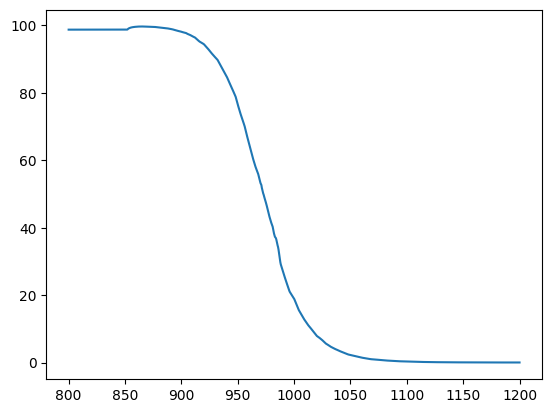

In [11]:
# инверсия просветления (нет усиления)

lmbda_1 = 800
lmbda_2 = 1200
Lmbdas_s = np.linspace(lmbda_1, lmbda_2, 1000)

N_bleach_spectral = s_12(Lmbdas_s, sigma)/(s_21(Lmbdas_s, sigma) + s_12(Lmbdas_s, sigma)) * 100
plt.plot(Lmbdas_s, N_bleach_spectral)

# чем больше длина волны, тем меньше инверсия просветления.
# при N > N bleach есть усиление
# чем длиннее волоновод, тем дольше усиливаются длинные волны
# для длинных волн длинное волокно - класс 